In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

In [21]:
class DataHandler:
    def __init__(self, batch_size_train=100, batch_size_test=100, data_dir='./data'):
        self.batch_size_train = batch_size_train
        self.batch_size_test = batch_size_test
        self.data_dir = data_dir
        self.train_loader = None
        self.test_loader = None
        self.classes = ('plane', 'car', 'bird', 'cat',
                       'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        self.load_data()

    def load_data(self):
        transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010))
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010))
        ])

        train_set = torchvision.datasets.CIFAR10(root=self.data_dir, train=True,
                                                 download=True, transform=transform_train)
        self.train_loader = torch.utils.data.DataLoader(train_set, batch_size=self.batch_size_train,
                                                       shuffle=True, num_workers=0)

        test_set = torchvision.datasets.CIFAR10(root=self.data_dir, train=False,
                                                download=True, transform=transform_test)
        self.test_loader = torch.utils.data.DataLoader(test_set, batch_size=self.batch_size_test,
                                                      shuffle=False, num_workers=0)

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [30]:
class Trainer:
    def __init__(self, model, train_loader, test_loader, device, criterion, optimizer, num_epochs):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.train_losses = []
        self.test_losses = []
        self.test_accuracies = []

    def train(self):
        self.model.train()
        for epoch in range(self.num_epochs):
            running_loss = 0.0
            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            avg_train_loss = running_loss / len(self.train_loader)
            self.train_losses.append(avg_train_loss)
            print(f'Epoch [{epoch + 1}/{self.num_epochs}] Train Loss: {avg_train_loss:.4f}')
            self.test()

        print('Обучение завершено.')

    def test(self):
        self.model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_test_loss = test_loss / len(self.test_loader)
        accuracy = 100 * correct / total
        self.test_losses.append(avg_test_loss)
        self.test_accuracies.append(accuracy)
        print(f'Test Loss: {avg_test_loss:.4f} Test Accuracy: {accuracy:.2f}%')

    def plot_history(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, self.num_epochs + 1), self.train_losses, label='Train Loss')
        plt.xlabel('Эпоха')
        plt.ylabel('Потеря')
        plt.title('Изменение ошибки во время обучения')
        plt.legend()

        plt.subplot(1, 2, 2)
        if self.test_accuracies:
            plt.plot(range(1, len(self.test_accuracies) + 1), self.test_accuracies, label='Test Accuracy', color='green')
            plt.xlabel('Эпоха')
            plt.ylabel('Точность (%)')
            plt.title('Точность на тестовой выборке')
            plt.legend()

        plt.tight_layout()
        plt.show()


In [28]:
class Evaluator:
    def __init__(self, model, device, test_loader, classes):
        self.model = model.to(device)
        self.device = device
        self.test_loader = test_loader
        self.classes = classes

    def imshow(self, img):
        img = img / 2 + 0.5
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
        plt.show()

    def plot_confusion_matrix(self):
        self.model.eval()
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        cm = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.classes, yticklabels=self.classes)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

In [12]:
data_handler = DataHandler(batch_size_train=100, batch_size_test=100)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Используем устройство: {device}')

Используем устройство: cuda


In [15]:
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


Epoch [1/5] Train Loss: 0.7123
Test Loss: 0.5824 Test Accuracy: 80.48%
Epoch [2/5] Train Loss: 0.4500
Test Loss: 0.5817 Test Accuracy: 80.80%
Epoch [3/5] Train Loss: 0.4410
Test Loss: 0.5835 Test Accuracy: 80.71%
Epoch [4/5] Train Loss: 0.4315
Test Loss: 0.5802 Test Accuracy: 81.08%
Epoch [5/5] Train Loss: 0.4322
Test Loss: 0.5769 Test Accuracy: 80.84%
Обучение завершено.
Test Loss: 0.5769 Test Accuracy: 80.84%


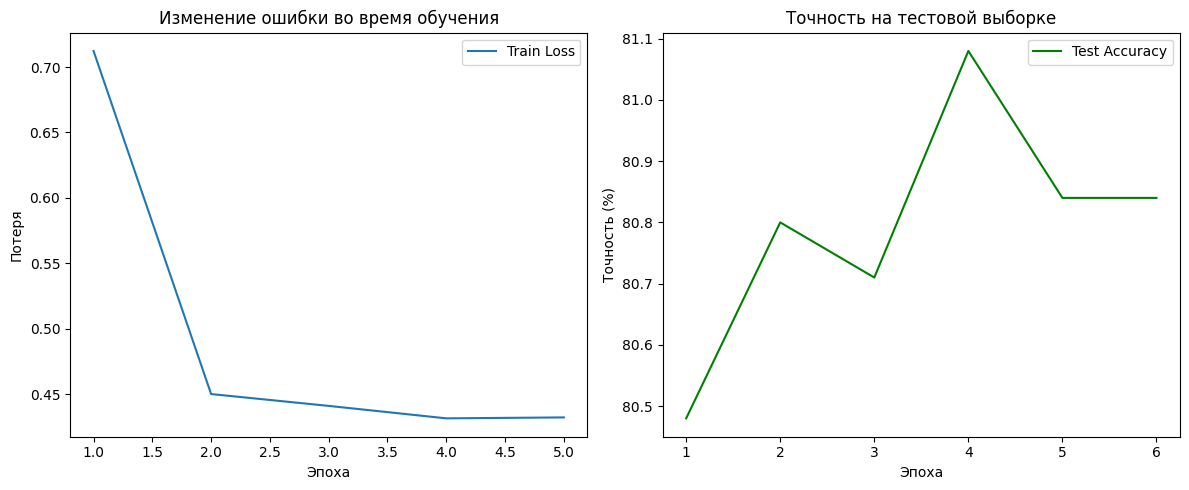

In [32]:
trainer = Trainer(device=device, model=model, train_loader=data_handler.train_loader,
                      test_loader=data_handler.test_loader, criterion=nn.CrossEntropyLoss(),
                      optimizer=optim.Adam(model.parameters(), lr=0.0001), num_epochs=5)

trainer.train()
trainer.test()

trainer.plot_history()

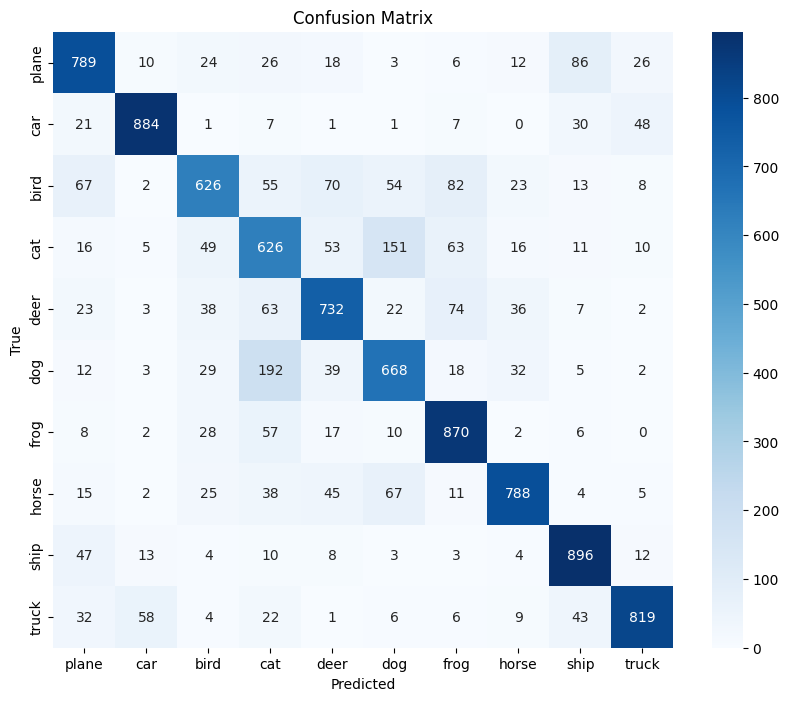

In [29]:
evaluator = Evaluator(model=model, device=device, test_loader=data_handler.test_loader,
                          classes=data_handler.classes)
evaluator.plot_confusion_matrix()